In [9]:
import sys
from pathlib import Path
import os
import numpy as np
from tb_hamiltonian import TBHamiltonian
from tb_hamiltonian.potentials import PotentialFactory
from tb_hamiltonian.utils import get_structure

sys.tracebacklimit = None

# Necessary when connecting to a jupyterhub kernel running on daint via VScode. NOT required otherwise

new_path = '/scratch/snx3000/ajayaraj/tests/periodic-potential/daint/BLG/tb-hamiltonian'
os.chdir(new_path)


In [10]:
# import ipcmagic
# import ipyparallel as ipp
# %ipcluster start -n 2 --launcher mpirun
# c = ipp.Client()
# c.ids

In [11]:
nn = 1  # number of nearest neighbors | don't use 0!

workdir = Path(".")

# lengths
# lx = 5.0  # length in x direction (Å)
# ly = 2.7
# # ly = lx / np.sqrt(3)  # length in y direction (Å) keeping the b/a ratio
# lz = 10  # length in z direction (Å)
# basepath = workdir / f"len_{lx}x{round(ly,3)}/nn_{nn}"

# or, repetitions
nx = 4  # number of repetitions in x direction
ny = 4  # number of repetitions in y direction
nz = 1  # number of repetitions in z direction
basepath = workdir / f"rep_{nx}x{ny}/nn_{nn}"

basepath.mkdir(parents=True, exist_ok=True)


In [12]:
# Define structure

structure = get_structure(
    unit_cell_filepath=workdir / "POSCAR",  # local unit cell file
    # lengths=(lx, ly, lz),
    repetitions=(nx, ny, nz),
    # structure_filepath=workdir
)

structure.info["label"] = "BLG"  # will show up at top of Hamiltonian output file

structure.write(basepath / "POSCAR", format="vasp")

In [13]:
# Compute H

H = TBHamiltonian(
    structure=structure,
    nearest_neighbor=nn,
    distances=(0.0, 1.425, 2.468, 2.850),
    hopping_parameters=(0.0, -2.7, 0.0, -0.27),
    interlayer_coupling=0.33,
)

H.build()

In [14]:
# Apply onsite term

potential = PotentialFactory("null")
potential.params = {
    "amplitude": 0.15,
    # "width": 0.5,
}
H.update_onsite_terms(
    onsite_term=0.0,
    potential=potential,
    alpha=(1.0, 1.0),
)
path = (
    basepath / f"{potential.name}"
    # / f"amplitude_{potential.params['amplitude']}"
    # / f"width_{potential.params['width']}"
)
path.mkdir(parents=True, exist_ok=True)

In [15]:
# Write H to file
# %%px
H.write_to_file(path)


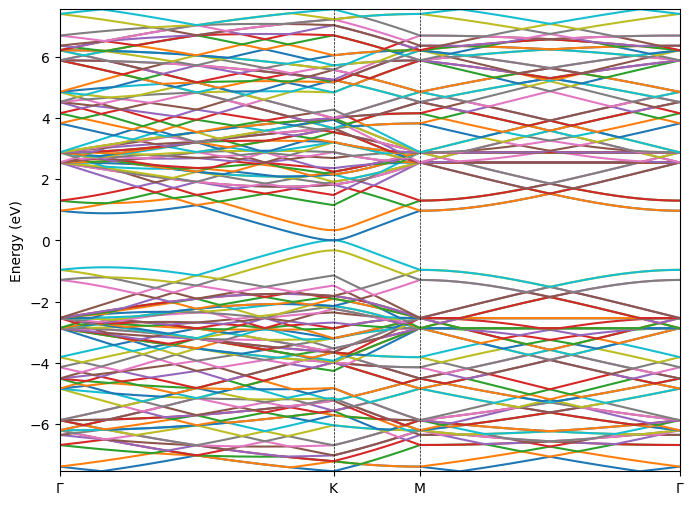

In [23]:
# Plotting
H.plot_bands(
    high_sym_points={
        "Γ": (0.00000, 0.00000, 0.00000),
        "P": (0.00000, 0.33333, 0.00000),
        "X": (0.00000, 0.50000, 0.00000),
        "Y": (0.50000, 0.00000, 0.00000),
        "K": (1.0000, 0.33333, 0.00000),
        "M": (1.0000, 0.00000, 0.00000),
    },
    k_path="Γ K M Γ",
    points_per_segment=120,
    use_sparse_solver=True,
    sparse_solver_params={"k": 120, "sigma": 1e-8},
    use_mpi=False,
    # fig_params={"ylim":(-1.5,1.5)},
    workdir=path,
    # mode="scatter",
    # plot_params={"s":5}
)